作成者：@MO_organizer

# CNN + RNNによる日付文字認識

参考：[Image Captioning with Attention](https://www.tensorflow.org/beta/tutorials/text/image_captioning)

## 準備

データのマウント

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp gdrive/My\ Drive/Python3/fujifilm/input-8307b45d-57f6-4190-a141-50d5bf233507.zip .
!unzip -q input-8307b45d-57f6-4190-a141-50d5bf233507.zip

モジュールのバージョン確認

In [0]:
# !pip list

モジュールのインポート

In [0]:
import json
from difflib import SequenceMatcher
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageEnhance
from tensorflow import keras
from tensorflow.keras import backend as K
from tqdm import tnrange as trange

sns.set()

ハイパーパラメータ等

In [0]:
character_list = [str(i) for i in range(10)]
character_list += [' ']

# 文字 -> id
tokenizer = {'<pad>': 0, '<start>': 1, '<end>': 2}
tokenizer.update({
    char: token + len(tokenizer)
    for char, token in zip(character_list, range(len(character_list)))})

# id -> 文字
detokenizer = {token: char for char, token in tokenizer.items()}

input_shape = (256, 512, 3)
max_string_length = 11
num_characters = len(tokenizer)
emb_dim = 512
hid_dim = 256

batch_size = 16
epochs = 64
log_dir = Path('logs')

In [0]:
# tokenizer.items()

## 学習

In [0]:
# モデル定義
def build_model(input_shape, max_string_length, num_characters, emb_dim,
                hid_dim):
    # == training ==============================================================
    # encoder
    input_images = keras.layers.Input(input_shape)
    x = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=input_images).get_layer(
            'activation_21').output
    features = keras.layers.Reshape((-1, K.int_shape(x)[-1]))(x)

    # attention
    W1 = keras.layers.Dense(hid_dim)
    W2 = keras.layers.Dense(hid_dim)
    V = keras.layers.Dense(1)

    expand_dims = keras.layers.Lambda(lambda x: K.expand_dims(x, axis=1))
    tanh = keras.layers.Activation('tanh')
    add = keras.layers.Add()
    attention_softmax = keras.layers.Softmax(axis=1)
    dot = keras.layers.Dot(axes=(1, 1))

    # decoder
    input_strings = keras.layers.Input((max_string_length,))
    embedding = keras.layers.Embedding(num_characters, emb_dim)
    gru = keras.layers.CuDNNGRU(
        hid_dim, recurrent_initializer='glorot_uniform', return_sequences=True,
        return_state=True)
    fc1 = keras.layers.Dense(hid_dim)
    fc2 = keras.layers.Dense(num_characters)
    output_softmax = keras.layers.Softmax()

    input_states = keras.layers.Input((hid_dim,))
    concat = keras.layers.Concatenate()

    embedded = embedding(input_strings)
    embedded = keras.layers.Dropout(0.5)(embedded)
    features = keras.layers.Dropout(0.5)(features)
    W1_features = W1(features)

    states = input_states
    outputs = []
    for i in range(max_string_length):
        score = V(tanh(add([W1_features, W2(expand_dims(states))])))
        attention_weights = attention_softmax(score)
        context_vector = dot([attention_weights, features])

        sliced_embedded = keras.layers.Lambda(
            lambda x: x[:, i:i + 1])(embedded)
        x = concat([context_vector, sliced_embedded])
        x, states = gru(x, initial_state=states)
        outputs.append(x)
    outputs = keras.layers.concatenate(outputs, axis=1)
    outputs = keras.layers.Dropout(0.5)(outputs)
    outputs = fc1(outputs)
    outputs = keras.layers.Dropout(0.5)(outputs)
    outputs = fc2(outputs)
    outputs = output_softmax(outputs)
    encoder_decoder_model = keras.Model(
        [input_images, input_strings, input_states], outputs)

    # == inference =============================================================
    encoder_model = keras.Model(input_images, features)

    # attention + decoder
    input_features = keras.layers.Input(K.int_shape(features)[1:])
    input_characters = keras.layers.Input((1,))
    input_states = keras.layers.Input((hid_dim,))

    score = V(tanh(add([W1(input_features), W2(expand_dims(input_states))])))
    attention_weights = attention_softmax(score)
    context_vector = dot([attention_weights, input_features])

    x = concat([context_vector, embedding(input_characters)])
    x, states = gru(x, initial_state=input_states)
    outputs = output_softmax(fc2(fc1(x)))

    decoder_model = keras.Model(
        [input_features, input_characters, input_states],
        [outputs, states, attention_weights])
    return encoder_decoder_model, encoder_model, decoder_model

In [0]:
# 画像読み込み
def load_image(path, training):
    image = Image.open(path)
    if training:
        enhancer_fn_list = [
            ImageEnhance.Brightness, ImageEnhance.Color, ImageEnhance.Contrast,
            ImageEnhance.Sharpness]
        for enhancer_fn in np.random.permutation(enhancer_fn_list):
            enhancer = enhancer_fn(image)
            image = enhancer.enhance(np.random.uniform(0.5, 1.5))
    image = np.array(image, dtype='f')
    image /= 255
    return image

In [0]:
# 画像とラベルを読み込むジェネレータ
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_path_list, tokens_list, batch_size, training):
        self.image_path_list = image_path_list
        self.tokens_list = tokens_list
        self.batch_size = batch_size
        self.training = training

        self.indices = np.arange(len(self.image_path_list))
        if self.training:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_path_list) / self.batch_size))

    def __getitem__(self, i):
        indices = self.indices[i * self.batch_size:(i + 1) * self.batch_size]
        images = np.array([
            load_image(self.image_path_list[idx], self.training)
            for idx in indices])

        labels = [
            ([tokenizer['<start>']] + self.tokens_list[idx]
                + [tokenizer['<end>']])
            for idx in indices]

        # labels: [batch_size, max_string_length + 1]
        labels = keras.preprocessing.sequence.pad_sequences(
            labels, maxlen=max_string_length + 1, padding='post',
            value=tokenizer['<pad>'])

        # target_labels: [batch_size, max_string_length, num_characters]
        target_labels = keras.utils.to_categorical(
            labels[:, 1:], len(tokenizer))

        # labels: [batch_size, max_string_length]
        labels = labels[:, :-1]

        # initialize hidden states.
        states = np.zeros((len(images), hid_dim), dtype='f')
        return [images, labels, states], target_labels

    def on_epoch_end(self):
        if self.training:
            np.random.shuffle(self.indices)

    def save_as_csv(self, save_path):
        pd.DataFrame([
            [path] + [str(token) for token in tokens]
            for path, tokens in zip(
                self.image_path_list, self.tokens_list)]
        ).to_csv(save_path, index=False, header=None)

In [0]:
# クロスエントロピー
def loss_fn(y_true, y_pred):
    # y_true, y_pred: [batch_size, max_string_length, num_characters]
    
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred)

    # <pad>が入力の時の損失は無視する
    pad_idx = tokenizer['<pad>']
    loss *= K.cast(
        K.not_equal(y_true[:, :, pad_idx:pad_idx + 1], 1), loss.dtype)
    return - K.sum(loss, axis=-1)

日付あり画像のみを学習に使用

In [0]:
json_path_list = sorted(Path('input/train_anns').glob('*.json'))
image_path_list = [
    Path(str(path).replace('_anns', '_images')).with_suffix('.jpg')
    for path in json_path_list]

tokens_list = []
for json_path in json_path_list:
    with open(json_path, 'r') as fo:
        json_dict = json.load(fo)
    string = json_dict['label']
    character_list = [i for i in string]
    tokens_list.append([tokenizer[char] for char in character_list])

注文IDが重複しないようにデータを分割

In [0]:
order_id_list = [
    int(path.name.split('_')[1].replace('id', ''))
    for path in image_path_list]
train_order_ids, valid_order_ids = np.split(
    np.random.RandomState(seed=42).permutation(sorted(set(order_id_list))),
    [int(0.9 * len(set(order_id_list)))])

train_indices = [
    i for i in range(len(order_id_list))
    if order_id_list[i] in train_order_ids]
train_data_gen = DataGenerator(
    [image_path_list[i] for i in train_indices],
    [tokens_list[i] for i in train_indices], batch_size, True)
train_data_gen.save_as_csv('list_train.csv')

valid_indices = [
    i for i in range(len(order_id_list))
    if order_id_list[i] in valid_order_ids]
valid_data_gen = DataGenerator(
    [image_path_list[i] for i in valid_indices],
    [tokens_list[i] for i in valid_indices], batch_size, False)
valid_data_gen.save_as_csv('list_valid.csv')

モデル初期化

In [0]:
model, _, _ = build_model(
    input_shape, max_string_length, num_characters, emb_dim, hid_dim)
model.compile(loss=loss_fn, optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0620 03:29:24.760073 139776090109824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0620 03:29:24.765819 139776090109824 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument i

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 256, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

学習（所要時間：約2時間30分）

In [0]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir=str(log_dir)),
    keras.callbacks.ModelCheckpoint(
        filepath=str(log_dir / 'weights-epoch{epoch:04}.h5'),
        save_weights_only=True)]

history = model.fit_generator(
    train_data_gen, epochs=epochs, callbacks=callbacks,
    validation_data=valid_data_gen, shuffle=False)
#     validation_data=valid_data_gen, shuffle=True)

W0620 03:29:32.468512 139776090109824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
350/350 [==============================] - 174s 498ms/step - loss: 1.2595 - acc: 0.3678 - val_loss: 0.9958 - val_acc: 0.3851
Epoch 2/70
350/350 [==============================] - 149s 426ms/step - loss: 1.0063 - acc: 0.4233 - val_loss: 0.9872 - val_acc: 0.3982
Epoch 3/70
350/350 [==============================] - 149s 426ms/step - loss: 0.9560 - acc: 0.4380 - val_loss: 0.9437 - val_acc: 0.4040
Epoch 4/70
350/350 [==============================] - 149s 426ms/step - loss: 0.9178 - acc: 0.4550 - val_loss: 1.2107 - val_acc: 0.3707
Epoch 5/70
350/350 [==============================] - 149s 426ms/step - loss: 0.8968 - acc: 0.4633 - val_loss: 0.9373 - val_acc: 0.4153
Epoch 6/70
350/350 [==============================] - 149s 427ms/step - loss: 0.8840 - acc: 0.4679 - val_loss: 0.9472 - val_acc: 0.3996
Epoch 7/70
350/350 [==============================] - 149s 427ms/step - loss: 0.8701 - acc: 0.4711 - val_loss: 0.9422 - val_acc: 0.4088
Epoch 8/70
350/350 [============================

In [0]:
!cp logs/weights-epoch0064.h5 gdrive/My\ Drive/Python3/fujifilm/data/weights/

損失関数の値を確認

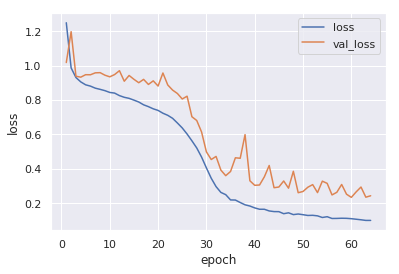

In [0]:
for name in ['loss', 'val_loss']:
    plt.plot([e + 1 for e in history.epoch], history.history[name], label=name)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

精度を確認

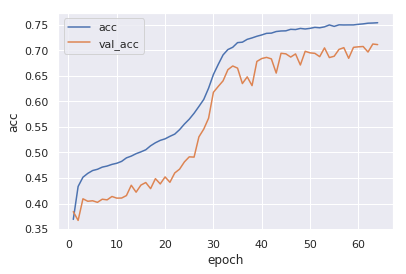

In [0]:
for name in ['acc', 'val_acc']:
    plt.plot([e + 1 for e in history.epoch], history.history[name], label=name)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

## 検証

In [0]:
# 推論用モデルを読み込む
def load_trained_model():
    K.clear_session()
    model, encoder_model, decoder_model = build_model(
        input_shape, max_string_length, num_characters, emb_dim, hid_dim)
    model.load_weights(f'{log_dir}/weights-epoch{epochs:04}.h5')
    return encoder_model, decoder_model

In [0]:
# 一文字ずつ推定する
def inference(input_image, encoder_model, decoder_model):
    # input_image: [1, height, width, channels]

    def log(x):
        x = np.clip(x, 1e-10, x)
        x = np.log(x)
        return x

    feature = encoder_model.predict(input_image)

    character = np.full((1, 1), tokenizer['<start>'], dtype='f')
    state = np.zeros((1, hid_dim), dtype='f')

    predicted_tokens = np.zeros(max_string_length, dtype='i')
    scores = np.zeros(max_string_length, dtype='f')
    for i in range(max_string_length):
        # output: [1, 1, num_characters]
        output, state, attention_weight = decoder_model.predict(
            [feature, character, state])

        # character: [1, 1]
        character = np.argmax(output, axis=-1)

        c = character[0, 0]
        if c == tokenizer['<end>']:
            break
        predicted_tokens[i] = c
        scores[i] = log(output[0, 0, c])

    # 出力を切り詰める
    predicted_tokens = predicted_tokens[scores != 0]
    scores = scores[scores != 0]

    # 確信度が小さければ空白を出力する
    if scores.mean() < log(0.9):
        predicted_tokens = []
    return predicted_tokens

推論（所要時間：約3分）

In [0]:
# 検証用データを読み込む
df = pd.read_csv('list_valid.csv', header=None, dtype=str)
image_path_list = df.iloc[:, 0].tolist()
tokens_list = [
    df.iloc[i, 1:].dropna().astype(int).tolist() for i in range(len(df))]

# 日付なし画像の一部に対しても検証を行う
unlabeled_image_list = sorted([
    str(path) for path in sorted(Path('input/train_images').glob('*.jpg'))
    if not Path(str(path).replace('_images', '_anns')).with_suffix(
        '.json').exists()])
image_path_list += np.random.RandomState(seed=42).permutation(
    unlabeled_image_list)[:int(0.1 * len(unlabeled_image_list))].tolist()
tokens_list += [[] for _ in range(len(image_path_list) - len(tokens_list))]

encoder_model, decoder_model = load_trained_model()

y_pred_list = []
y_true_list = []
for i in trange(len(tokens_list)):
    input_image = load_image(image_path_list[i], False)[None]
    predicted_tokens = inference(
        input_image, encoder_model, decoder_model)

    # [12, 11, 13, 4, 13, 5, 6] -> ['9', '8', ' ', '1', ' ', '2', '3']
    y_pred = [detokenizer[token] for token in predicted_tokens]
    y_true = [detokenizer[token] for token in tokens_list[i]]

    # ['9', '8', ' ', '1', ' ', '2', '3'] -> '98 1 23'
    y_pred_list.append(''.join(y_pred))
    y_true_list.append(''.join(y_true))

scores = np.zeros(len(image_path_list), dtype='f')
for i, (y_true, y_pred) in enumerate(zip(y_true_list, y_pred_list)):
    s = SequenceMatcher(None, y_true.split(' '), y_pred.split(' '))
    scores[i] = s.ratio()
scores.mean()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


0.8555773

In [0]:
def show_result(i):
    title = (
        f"""name: {image_path_list[i].split('/')[-1]}, score: {scores[i]:.3f}
        true: '{y_true_list[i]}', pred: '{y_pred_list[i]}'""")
    plt.title(title)
    plt.imshow(np.array(Image.open(image_path_list[i])) / 255.)
    plt.xticks([])
    plt.yticks([])
    plt.show()

日付あり画像に対する誤検出

In [0]:
# indices = np.where(
#     (np.array(y_true_list) != '') * (scores > 0) * (scores < 1))[0]
# for i in indices[:3]:
#     show_result(i)

日付あり画像に対する未検出

In [0]:
# indices = np.where(
#     (np.array(y_true_list) != '') * (np.array(y_pred_list) == ''))[0]
# for i in indices[:3]:
#     show_result(i)

日付なし画像に対する誤検出

In [0]:
# indices = np.where(
#     (np.array(y_true_list) == '') * (np.array(y_pred_list) != ''))[0]
# for i in indices[:3]:
#     show_result(i)

## 提出用ファイル作成

推論（所要時間：約11分）

In [0]:
image_path_list = sorted(Path('input/test_images').glob('*.jpg'))
encoder_model, decoder_model = load_trained_model()

y_pred_list = []
for i in trange(len(image_path_list)):
    input_image = load_image(image_path_list[i], False)[None]
    predicted_tokens = inference(
        input_image, encoder_model, decoder_model)
    y_pred = [detokenizer[token] for token in predicted_tokens]
    y_pred_list.append(''.join(y_pred))

df = pd.DataFrame()
df['name'] = [path.name for path in image_path_list]
df['label'] = y_pred_list
df.to_csv('result_cnn_colab_pre.csv', index=False, header=None)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


提出用ファイルの先頭の一部を確認

In [0]:
df.head()

,name,label
0,test_id0001_no0001.jpg,
1,test_id0001_no0002.jpg,
2,test_id0001_no0003.jpg,94 89
3,test_id0001_no0004.jpg,94 89
4,test_id0001_no0005.jpg,94 89


提出用ファイルをダウンロード

In [0]:
from google.colab import files
files.download('result_cnn_colab_pre.csv')

# 出力結果の整形

In [0]:
# ダウンロードしたファイルをアップでも再開できる
from google.colab import files
# files.upload()
# df = pd.read_csv("result_cnn_colab_pre.csv", header=None)

Saving result_cnn_colab_pre.csv to result_cnn_colab_pre.csv


{'result_cnn_colab_pre.csv': b'test_id0001_no0001.jpg,\ntest_id0001_no0002.jpg,\ntest_id0001_no0003.jpg,94 89\ntest_id0001_no0004.jpg,94 89\ntest_id0001_no0005.jpg,94 89\ntest_id0001_no0006.jpg,\ntest_id0001_no0007.jpg,\ntest_id0001_no0008.jpg,\ntest_id0001_no0009.jpg,8 9 98\ntest_id0001_no0010.jpg,948 8\ntest_id0001_no0011.jpg,94 89\ntest_id0001_no0012.jpg,888 15\ntest_id0001_no0013.jpg,94 8 8\ntest_id0001_no0014.jpg,94 8 8\ntest_id0001_no0015.jpg,\ntest_id0001_no0016.jpg,\ntest_id0001_no0017.jpg,\ntest_id0001_no0018.jpg,\ntest_id0001_no0019.jpg,\ntest_id0001_no0020.jpg,\ntest_id0001_no0021.jpg,\ntest_id0001_no0022.jpg,\ntest_id0001_no0023.jpg,\ntest_id0001_no0024.jpg,\ntest_id0001_no0025.jpg,\ntest_id0001_no0026.jpg,\ntest_id0001_no0027.jpg,\ntest_id0001_no0028.jpg,\ntest_id0001_no0029.jpg,\ntest_id0001_no0030.jpg,\ntest_id0001_no0031.jpg,\ntest_id0001_no0032.jpg,\ntest_id0001_no0033.jpg,\ntest_id0001_no0034.jpg,\ntest_id0001_no0035.jpg,\ntest_id0001_no0036.jpg,\ntest_id0001_no0037.j

In [0]:
# 予測結果をいい感じに整形する
def reshape_predict(predict):
  if len(predict) in [0, 1]:
    predict = ""
    return predict
# 連続7,8文字
  if len(predict) in [7, 8] and " " not in predict:
    predict = predict[:4]+" "+predict[4:6]+" "+predict[6:]
#     print("A")
# 連続6文字
  elif len(predict)==6 and " " not in predict:
    if re.search("^20[0-1][0-9]+", predict):
      predict = predict[:4]+" "+predict[4]+" "+predict[5]
    else:
      predict = predict[:2]+" "+predict[2:4]+" "+predict[4:]
#     print("B")
# 連続5文字
  elif len(predict)==5 and " " not in predict:
    predict = predict[:2]+" "+predict[2]+" "+predict[3:]
#     print("C")
# 連続4文字
  elif len(predict)==4 and " " not in predict:
    predict = predict[:2]+" "+predict[2]+" "+predict[3]
#     print("C2")
  tmp = predict.split(" ")
# 2分割できる場合
  if len(tmp)==2:
# ありえない文字列
    if len(tmp[0])==3:
      predict = tmp[0][:2]+" "+tmp[0][2]+" "+tmp[1]
#       print("D")
# ありえない文字列
    elif len(tmp[1])==3:
      predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1:]
#       print("E")
# 9X XX
    elif re.search("^9[0-9]$", tmp[0]) and len(tmp[1])==2:
      predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1]
#       print("F")
# 20XX XX
    elif len(tmp[0])==4 and len(tmp[1])==2:
      if re.search("20[0-1][0-9]", tmp[0]):
        predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1]
      else:
        predict = tmp[0][:2]+" "+tmp[0][2:]+" "+tmp[1]
#       print("G")
# 20XX X
    elif len(tmp[0])==4 and len(tmp[1])==1:
      if re.search("20[0-1][0-9]", tmp[0]):
        pass
      else:
        predict = tmp[0][:2]+" "+tmp[0][2:]+" "+tmp[1]
#       print("G2")
# 20XXX
    elif re.search("20[0-1][0-9][0-9]+", tmp[0]):
      predict = tmp[0][:4]+" "+tmp[0][4:]+" "+tmp[1]
#       print("H")
# XXXX XX
    elif len(tmp[1])==4:
      predict = tmp[0]+" "+tmp[1][:2]+" "+tmp[1][2:]
#       print("H2")
# X XX
    elif len(tmp[0]) in [1, 2] and len(tmp[1])==2:
      predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1]
#       print("H3")
# XX X
    elif len(tmp[0])==2 and len(tmp[1])==1:
      predict = tmp[0][0]+" "+tmp[0][1]+" "+tmp[1]
#       print("H4")
# 3分割できる場合
  if len(predict.split(" "))==3:
    tmp = predict.split(" ")
# ありえない文字列
    if re.search("^[4-9][0-9]$",tmp[1]) and len(tmp[2])==1:
      predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1]+tmp[2]
    elif re.search("^0$",tmp[1]) and len(tmp[2])==2:
      predict = tmp[0]+" "+tmp[1]+tmp[2][0]+" "+tmp[2][1]
    elif re.search("^[4-9][0-9]$",tmp[2]) and len(tmp[1])==1:
      predict = tmp[0]+" "+tmp[1]+tmp[2][0]+" "+tmp[2][1]
    elif re.search("^0$",tmp[2]) and len(tmp[1])==2:
      predict = tmp[0]+" "+tmp[1][0]+" "+tmp[1][1]+tmp[2]
      
  return predict

In [0]:
# 出力結果の整形
print("整形前　/　整形後")
for i in range(len(df)):
    predict = df.iat[i,1]
    if type(df.iat[i,1]) != float:
      predict = reshape_predict(predict)
      if df.iat[i,1] != predict:
        print(df.iat[i,1], "/", predict)
        df.iat[i,1] = predict

94 89 / 94 8 9
94 89 / 94 8 9
94 89 / 94 8 9
8 9 98 / 8 99 8
948 8 / 94 8 8
94 89 / 94 8 9
888 15 / 88 8 15
848 6 / 84 8 6
94724 / 94 7 24
947 23 / 94 7 23
94724 / 94 7 24
94724 / 94 7 24
947 30 / 94 7 30
94 730 / 94 7 30
939 30 / 93 9 30
998 2 / 99 8 2
998 2 / 99 8 2
998 2 / 99 8 2
998 2 / 99 8 2
998 2 / 99 8 2
998 2 / 99 8 2
998 29 / 99 8 29
998 29 / 99 8 29
998 22 / 99 8 22
9410 23 / 94 10 23
964 9 / 96 4 9
964 9 / 96 4 9
998 22 / 99 8 22
998 2 / 99 8 2
97 318 / 97 3 18
9411 13 / 94 11 13
9411 11 / 94 11 11
9411 13 / 94 11 13
9411 13 / 94 11 13
9411 13 / 94 11 13
9411 13 / 94 11 13
9411 13 / 94 11 13
9411 13 / 94 11 13
954 8 / 95 4 8
958 1 / 95 8 1
952 4 / 95 2 4
941018 / 94 10 18
9410 18 / 94 10 18
954 9 / 95 4 9
954 9 / 95 4 9
954 9 / 95 4 9
954 9 / 95 4 9
954 9 / 95 4 9
954 4 / 95 4 4
921022 / 92 10 22
921025 / 92 10 25
921025 / 92 10 25
92 1022 / 92 10 22
92 1022 / 92 10 22
92 1022 / 92 10 22
921017 / 92 10 17
921025 / 92 10 25
921017 / 92 10 17
929 13 / 92 9 13
924 10 / 92 4 10

In [0]:
# 保存
from google.colab import files
df.to_csv('result_cnn_colab.csv', index=False, header=None)
files.download('result_cnn_colab.csv')

In [0]:
df.to_csv("/content/gdrive/My Drive/Python3/fujifilm/data/result_cnn_colab.csv", header=False, index=False)